## 가상데이터생성 (CTGAN)_01

In [1]:
import torch
torch.cuda.current_device()

0

In [2]:
torch.cuda.device(0)

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import pickle
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
from collections import defaultdict
from itertools import islice, combinations
from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
# 폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic'


In [5]:
# GPU 메모리문제 해결
import torch,gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
#주피터 셀 전체화면보기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# 주피터 한 셀에 입력된 수시과 함수의 결과를 모두출력(선택사용)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
## 각 컬럼 width 최대로
pd.set_option('display.max_colwidth', -1)
## rows 500
pd.set_option('display.max_rows', 500)
## columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print('ready to run')
# 전체 시작시간 로깅
startTime = time.time()

ready to run


In [7]:
import os
import pickle
print(os.getcwd())

C:\Users\kcs\df_syn_generation_m


In [8]:
os.chdir("C:/Users/kcs/df_syn_generation_m")

## 3.  우범여부를 기준으로 데이터프레임 분할

In [9]:
# load and uncompress.
df_raw=pd.read_csv('./month/total.csv', encoding='utf-8-sig')

In [10]:
df_org_merge=df_raw[['신고번호', '신고일자', '신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드', '신고인부호', '수입자', '해외거래처부호','특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액', '우범여부', '핵심적발']]

In [11]:
df_org_merge['신고일자']=df_org_merge['신고일자'].astype(str)
df_org_merge['신고일자']=pd.to_datetime(df_org_merge['신고일자'])

In [12]:
df_org_merge.신고일자.sort_index(ascending=True).sort_values(ascending=True)

0        2020-01-01
68       2020-01-01
67       2020-01-01
66       2020-01-01
65       2020-01-01
            ...    
321725   2021-06-30
321726   2021-06-30
321727   2021-06-30
321720   2021-06-30
322144   2021-06-30
Name: 신고일자, Length: 322145, dtype: datetime64[ns]

In [13]:
df_org_merge['신고번호'].value_counts()

73478314    2
4485930     2
47735261    2
8598975     2
47115079    2
           ..
20327285    1
60831887    1
68411525    1
13172161    1
35702387    1
Name: 신고번호, Length: 321651, dtype: int64

In [14]:
df_org=df_org_merge.drop_duplicates(['신고번호'], keep='first')

In [15]:
df_org['신고번호'].value_counts()

5974087     1
406979      1
31596414    1
67699512    1
17246639    1
           ..
21439956    1
40460714    1
49268812    1
61767890    1
35702387    1
Name: 신고번호, Length: 321651, dtype: int64

In [16]:
df_org

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액,우범여부,핵심적발
0,5974087,2020-01-01,30,B,11,21,11,10,HUIUK4E,2VLNQNR,W3SU9E0,NaN,303390000,US,US,0.0,FUS5,B,30812.30,64066748,1,1
1,55227682,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,10168.06,17258717,1,1
2,89961821,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,5092.52,7768964,1,1
3,39640045,2020-01-01,30,B,11,21,11,10,NN47CLJ,C28EH18,O43S2D8,NaN,303390000,US,US,0.0,FUS5,B,82466.03,179543344,1,1
4,18737711,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,603.92,708706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322140,56952841,2021-06-30,16,B,11,21,11,10,8MTRQLF,7QHT111,9XKG8X1,NaN,910111000,CN,CN,377.3,W2,B,5760.00,7171666,0,0
322141,83095639,2021-06-30,16,B,11,21,11,10,CXWWNWO,EQEERAT,2UPXR6Z,NaN,9503001800,CN,CN,0.0,C,G,11167.30,55581650,0,0
322142,16736686,2021-06-30,30,B,11,21,11,10,12WCE9E,BDNR66A,U88BBZT,NaN,901110000,GT,GT,2.0,A,E,5280.00,32700882,0,0
322143,71331804,2021-06-30,40,B,15,21,11,40,UFO3ZSU,WH93Y1L,NaN,HMATUU,8473302000,CN,CN,0.0,C,E,29.00,2519224,0,0


In [17]:
df_org.columns

Index(['신고번호', '신고일자', '신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드', '신고인부호', '수입자', '해외거래처부호', '특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액', '우범여부', '핵심적발'], dtype='object')

In [18]:
df_org=df_org.sort_values(by=['신고일자'], axis = 0)

In [19]:
df_org_merge

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액,우범여부,핵심적발
0,5974087,2020-01-01,30,B,11,21,11,10,HUIUK4E,2VLNQNR,W3SU9E0,NaN,303390000,US,US,0.0,FUS5,B,30812.30,64066748,1,1
1,55227682,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,10168.06,17258717,1,1
2,89961821,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,5092.52,7768964,1,1
3,39640045,2020-01-01,30,B,11,21,11,10,NN47CLJ,C28EH18,O43S2D8,NaN,303390000,US,US,0.0,FUS5,B,82466.03,179543344,1,1
4,18737711,2020-01-01,30,B,11,21,11,10,HUIUK4E,C28EH18,VCX09HV,NaN,303390000,US,US,0.0,FUS5,B,603.92,708706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322140,56952841,2021-06-30,16,B,11,21,11,10,8MTRQLF,7QHT111,9XKG8X1,NaN,910111000,CN,CN,377.3,W2,B,5760.00,7171666,0,0
322141,83095639,2021-06-30,16,B,11,21,11,10,CXWWNWO,EQEERAT,2UPXR6Z,NaN,9503001800,CN,CN,0.0,C,G,11167.30,55581650,0,0
322142,16736686,2021-06-30,30,B,11,21,11,10,12WCE9E,BDNR66A,U88BBZT,NaN,901110000,GT,GT,2.0,A,E,5280.00,32700882,0,0
322143,71331804,2021-06-30,40,B,15,21,11,40,UFO3ZSU,WH93Y1L,NaN,HMATUU,8473302000,CN,CN,0.0,C,E,29.00,2519224,0,0


In [20]:
df_org.columns

Index(['신고번호', '신고일자', '신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드', '신고인부호', '수입자', '해외거래처부호', '특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액', '우범여부', '핵심적발'], dtype='object')

In [21]:
df_sample=df_org.sample(3000,replace=False)

In [22]:
df_sample.to_csv('./data_sample/df_sample_01.csv', index=False, encoding='utf-8-sig')

In [23]:
# 컬럼 합치기
cols = ['HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '신고중량(KG)','우범여부', '핵심적발']
df_sample['HS10_적_원_율_구_중_우_핵'] =df_sample[cols].apply(lambda row: '^'.join(row.values.astype(str)), axis=1)
df_sample=df_sample.drop(cols, axis=1)
df_sample=df_sample.drop(['과세가격원화금액'], axis=1)

In [24]:
df_sample

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10_적_원_율_구_중_우_핵
230890,95280514,2021-01-11,20,B,11,21,11,10,SWF9S4X,KHY327A,BXMTYM2,NaN,G,8504403010^CN^CN^0.0^C^171.763^0^0
4683,34239020,2020-01-08,62,B,11,21,11,10,I78OVK0,IZCM00P,PIFUTXX,NaN,G,9401699000^CN^CN^0.0^C^3870.0^0^0
220400,92981392,2020-12-19,40,B,11,21,18,40,PF1L1IG,1FSAJPY,5Y15VRI,MWIDNS,G,8536691000^GB^CN^0.0^C^0.01^0^0
74834,36372585,2020-04-23,40,B,89,21,18,40,DWNJQL8,2TBDKMY,NaN,W6UCD9,S,3822001011^TH^KR^0.0^C^3.9^0^0
150518,62592085,2020-08-20,20,B,11,21,11,10,UOOH9ZX,0VFPVSE,R1QK19S,NaN,B,3926909000^CN^CN^3.9^FCN1^80.0^0^0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172325,20266001,2020-09-28,16,B,15,21,11,10,K3HCKNK,U4WW4OX,NaN,FTHR76,E,8714990000^CN^CN^8.0^A^10.106^0^0
112454,99173189,2020-06-23,20,B,11,21,11,10,S0DA2NO,ORKFWQW,RZ0Z66D,NaN,S,7404000000^TH^TH^0.0^C^20204.0^0^0
231169,564943,2021-01-12,20,B,11,21,11,10,62RAPC6,Q3ESCVI,6BM86QF,NaN,G,3926909000^CN^CN^3.4^FCN1^237.572^0^0
320349,88414286,2021-06-28,20,B,11,21,11,10,YCWPB31,DJ45RKF,86S2O0A,NaN,G,9405403000^CN^CN^2.4^FCN1^238.0^1^2


In [25]:
df_sample.dtypes

신고번호                  int64         
신고일자                  datetime64[ns]
신고세관부호                int64         
수입신고구분코드              object        
수입거래구분코드              int64         
수입종류코드                int64         
징수형태코드                int64         
운송수단유형코드              int64         
신고인부호                 object        
수입자                   object        
해외거래처부호               object        
특송업체부호                object        
원산지표시유무코드             object        
HS10_적_원_율_구_중_우_핵    object        
dtype: object

In [26]:
df_sample['신고일자']=df_sample['신고일자'].astype('str')

In [27]:
df_sample.columns

Index(['신고번호', '신고일자', '신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드', '신고인부호', '수입자', '해외거래처부호', '특송업체부호', '원산지표시유무코드', 'HS10_적_원_율_구_중_우_핵'], dtype='object')

In [28]:
categorical_columns =[ '신고번호', '신고일자','수입신고구분코드','신고인부호','수입자','해외거래처부호','특송업체부호','원산지표시유무코드','HS10_적_원_율_구_중_우_핵']

In [29]:
from ctgan import CTGANSynthesizer
from ctgan import load_demo

In [30]:
#df_sample=df_org.sample(frac=0.15,replace=False)

In [31]:
df_sample.shape

(3000, 14)

In [32]:
# 가상데이터 생성기
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(df_sample, categorical_columns, epochs = 100)

Epoch 1, Loss G:  5.3592,Loss D: -0.1240
Epoch 2, Loss G:  5.4703,Loss D: -0.2332
Epoch 3, Loss G:  5.5018,Loss D: -0.2819
Epoch 4, Loss G:  5.4414,Loss D: -0.2830
Epoch 5, Loss G:  5.3600,Loss D: -0.3872
Epoch 6, Loss G:  5.2567,Loss D: -0.4319
Epoch 7, Loss G:  5.5430,Loss D: -0.4848
Epoch 8, Loss G:  5.5439,Loss D: -0.5703
Epoch 9, Loss G:  5.4590,Loss D: -0.5240
Epoch 10, Loss G:  5.5772,Loss D: -0.4643
Epoch 11, Loss G:  5.4801,Loss D: -0.4329
Epoch 12, Loss G:  5.2539,Loss D: -0.3303
Epoch 13, Loss G:  5.1778,Loss D: -0.1697
Epoch 14, Loss G:  4.8543,Loss D:  0.0526
Epoch 15, Loss G:  5.2357,Loss D: -0.0107
Epoch 16, Loss G:  4.8334,Loss D: -0.0355
Epoch 17, Loss G:  5.0521,Loss D:  0.0022
Epoch 18, Loss G:  4.7346,Loss D:  0.0723
Epoch 19, Loss G:  4.7487,Loss D:  0.1009
Epoch 20, Loss G:  4.4323,Loss D:  0.1800
Epoch 21, Loss G:  4.8012,Loss D:  0.1101
Epoch 22, Loss G:  4.7866,Loss D:  0.0331
Epoch 23, Loss G:  4.1800,Loss D:  0.0676
Epoch 24, Loss G:  4.5198,Loss D:  0.1351
E

In [33]:
# GPU 메모리문제 해결
import torch,gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
count_row = df_sample.shape[0] 

In [35]:
# 가상데이터 생성count_row
df_syn = ctgan.sample(count_row)

In [36]:
df_syn.신고번호.value_counts()

39051248    12
74397515    11
79375797    11
91852303    11
63341692    11
            ..
72547166    1 
96215102    1 
16933044    1 
20609837    1 
17848869    1 
Name: 신고번호, Length: 1430, dtype: int64

In [37]:
cols = ['HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '신고중량(KG)','우범여부', '핵심적발']

In [38]:
df_syn['HS10단위부호']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[0]
df_syn['적출국가코드']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[1]
df_syn['원산지국가코드']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[2]
df_syn['관세율']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[3]
df_syn['관세율구분코드']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[4]
df_syn['신고중량(KG)']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[5]
df_syn['우범여부']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[6]
df_syn['핵심적발']=df_syn.HS10_적_원_율_구_중_우_핵.str.split('^').str[7]

In [39]:
df_syn = df_syn.drop(['HS10_적_원_율_구_중_우_핵'],axis=1)

In [40]:
df_syn

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,신고중량(KG),우범여부,핵심적발
0,62882487,2020-10-08,67,B,11,21,11,40,SPUZ923,SZPFZPG,A70MDRN,NaN,B,3920100000,CN,CN,3.9,FCN1,18250.0,1,1
1,8225557,2020-12-04,21,B,11,21,11,10,ZQJIYI3,OPXBPE0,NPKQ6XY,NaN,Y,901110000,CO,CO,2.0,A,1.5,0,0
2,90002591,2020-08-10,20,B,11,21,19,10,K3E28IQ,X150A5P,1PIC948,NaN,B,9504209000,CN,CN,0.0,FCN1,361.0,1,1
3,46390760,2021-03-01,21,B,11,21,11,40,DWNJQL8,XH34UUD,F5CZ7VJ,NaN,E,6208921000,CN,CN,13.0,A,60.0,0,0
4,64392875,2020-05-15,40,B,90,21,15,40,NZYZ967,TTG1FPO,23QQBAY,MWIDNS,Y,8525803000,HK,CN,0.0,CIT,110.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,58851205,2021-05-19,32,B,11,21,11,10,SK0HQC0,EAJL78Z,L4O1TLK,NaN,E,6104620000,KH,KH,0.0,FAS1,1351.38,0,0
2996,17848869,2021-06-10,20,B,11,21,11,10,SMPOM2X,6OOSTGJ,5D0TSD0,NaN,E,6211431000,CN,CN,3.9,FCN1,198.766,1,1
2997,54266655,2020-05-18,33,B,11,21,45,10,51JSZLY,4PNT3W1,J6CQGJD,NaN,G,4823909090,CN,CN,0.0,C,10.0,0,0
2998,83758906,2021-01-11,22,B,11,21,12,9,QZE38LM,O7RSHF5,NaN,NaN,E,8501510000,JP,JP,8.0,A,21.5,0,0


In [41]:
# df_syn=df_syn.sort_values(by=['신고일자'], axis = 0)

In [42]:
# row_size = df_syn.shape[0]
# data = np.random.randint(10000000,99999999, size=row_size)
# data_list = np.array(data).tolist()
# df_syn=df_syn.drop(['신고번호'],axis=1)
# df_syn.insert(0,'신고번호', data_list)

In [43]:
pd.options.display.float_format = '{:.2f}'.format

In [44]:
df_price = pd.read_csv('./HS_단가적용.csv', encoding='949')

In [45]:
df_price

,Unnamed: 0,HS10단위코드,수,최소,최대,평균,표준편차,단가1,단가2,단가
0,0,3926909000,32189,1.15,2749598600.00,277126.19,16553295.63,0.60,1715542390.45,0.60
1,1,6402999000,2608,197.07,937621100.00,383910.35,18356535.02,102.81,687644820.87,102.81
2,2,5407520000,116,1872.72,2220111.00,44624.01,204988.97,977.01,1163281.23,977.01
3,3,8714990000,586,12.78,5984817.07,109676.93,390820.95,6.67,4282727.80,6.67
4,4,3923290000,929,15.18,55458600.00,85240.80,1819820.71,7.92,13323032.43,7.92
...,...,...,...,...,...,...,...,...,...,...
9375,9375,2921113010,1,3101.48,3101.48,3101.48,0.00,1618.06,3101.48,3101.48
9376,9376,2930903040,1,34581.33,34581.33,34581.33,0.00,18041.25,34581.33,34581.33
9377,9377,9031493000,1,474481.86,474481.86,474481.86,0.00,247539.53,474481.86,474481.86
9378,9378,7508902010,1,66896.39,66896.39,66896.39,0.00,34900.18,66896.39,66896.39


In [46]:
df_price.단가.value_counts

<bound method IndexOpsMixin.value_counts of 0      0.60     
1      102.81   
2      977.01   
3      6.67     
4      7.92     
       ...      
9375   3101.48  
9376   34581.33 
9377   474481.86
9378   66896.39 
9379   1422.66  
Name: 단가, Length: 9380, dtype: float64>

In [47]:
# 참조할 데이터프레임과 데이터타입 일치시킴
df_price['HS10단위코드']=df_price['HS10단위코드'].astype('str')
df_price['단가']=df_price['단가'].astype('float')

In [48]:
# HS10단위 중심으로 df_price 데이터프레임에서 단가를 가져옮
df_syn2=df_syn.join(df_price.set_index('HS10단위코드')['단가'], on='HS10단위부호')
df_syn2['신고중량(KG)'] = df_syn2['신고중량(KG)'].astype('float')

In [49]:
df_syn2

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,신고중량(KG),우범여부,핵심적발,단가
0,62882487,2020-10-08,67,B,11,21,11,40,SPUZ923,SZPFZPG,A70MDRN,NaN,B,3920100000,CN,CN,3.9,FCN1,18250.00,1,1,38.31
1,8225557,2020-12-04,21,B,11,21,11,10,ZQJIYI3,OPXBPE0,NPKQ6XY,NaN,Y,901110000,CO,CO,2.0,A,1.50,0,0,609.87
2,90002591,2020-08-10,20,B,11,21,19,10,K3E28IQ,X150A5P,1PIC948,NaN,B,9504209000,CN,CN,0.0,FCN1,361.00,1,1,1455.92
3,46390760,2021-03-01,21,B,11,21,11,40,DWNJQL8,XH34UUD,F5CZ7VJ,NaN,E,6208921000,CN,CN,13.0,A,60.00,0,0,82.57
4,64392875,2020-05-15,40,B,90,21,15,40,NZYZ967,TTG1FPO,23QQBAY,MWIDNS,Y,8525803000,HK,CN,0.0,CIT,110.00,1,1,455.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,58851205,2021-05-19,32,B,11,21,11,10,SK0HQC0,EAJL78Z,L4O1TLK,NaN,E,6104620000,KH,KH,0.0,FAS1,1351.38,0,0,923.88
2996,17848869,2021-06-10,20,B,11,21,11,10,SMPOM2X,6OOSTGJ,5D0TSD0,NaN,E,6211431000,CN,CN,3.9,FCN1,198.77,1,1,51.76
2997,54266655,2020-05-18,33,B,11,21,45,10,51JSZLY,4PNT3W1,J6CQGJD,NaN,G,4823909090,CN,CN,0.0,C,10.00,0,0,9.22
2998,83758906,2021-01-11,22,B,11,21,12,9,QZE38LM,O7RSHF5,NaN,NaN,E,8501510000,JP,JP,8.0,A,21.50,0,0,21.32


In [50]:
df_syn2['신고중량(KG)'] = df_syn2['신고중량(KG)'].round(1)
df_syn2['단가'] = df_syn2['단가'].round(1)

In [51]:
df_syn2['과세가격원화금액'] = df_syn2['신고중량(KG)']* df_syn2['단가']

In [52]:
df_syn2.head(5)

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,신고중량(KG),우범여부,핵심적발,단가,과세가격원화금액
0,62882487,2020-10-08,67,B,11,21,11,40,SPUZ923,SZPFZPG,A70MDRN,NaN,B,3920100000,CN,CN,3.9,FCN1,18250.00,1,1,38.30,698975.00
1,8225557,2020-12-04,21,B,11,21,11,10,ZQJIYI3,OPXBPE0,NPKQ6XY,NaN,Y,901110000,CO,CO,2.0,A,1.50,0,0,609.90,914.85
2,90002591,2020-08-10,20,B,11,21,19,10,K3E28IQ,X150A5P,1PIC948,NaN,B,9504209000,CN,CN,0.0,FCN1,361.00,1,1,1455.90,525579.90
3,46390760,2021-03-01,21,B,11,21,11,40,DWNJQL8,XH34UUD,F5CZ7VJ,NaN,E,6208921000,CN,CN,13.0,A,60.00,0,0,82.60,4956.00
4,64392875,2020-05-15,40,B,90,21,15,40,NZYZ967,TTG1FPO,23QQBAY,MWIDNS,Y,8525803000,HK,CN,0.0,CIT,110.00,1,1,455.70,50127.00


In [53]:
df_syn2[df_syn2.과세가격원화금액.isnull()]

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,신고중량(KG),우범여부,핵심적발,단가,과세가격원화금액


In [54]:
pd.options.display.float_format = '{:.2f}'.format

In [55]:
round(df_syn2.과세가격원화금액.describe(),5)

count   3000.00     
mean    2425272.33  
std     18483013.67 
min     0.00        
25%     685.88      
50%     11205.40    
75%     348040.70   
max     647799960.00
Name: 과세가격원화금액, dtype: float64

In [56]:
df_syn2.head(100)

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,원산지표시유무코드,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,신고중량(KG),우범여부,핵심적발,단가,과세가격원화금액
0,62882487,2020-10-08,67,B,11,21,11,40,SPUZ923,SZPFZPG,A70MDRN,NaN,B,3920100000,CN,CN,3.9,FCN1,18250.00,1,1,38.30,698975.00
1,8225557,2020-12-04,21,B,11,21,11,10,ZQJIYI3,OPXBPE0,NPKQ6XY,NaN,Y,901110000,CO,CO,2.0,A,1.50,0,0,609.90,914.85
2,90002591,2020-08-10,20,B,11,21,19,10,K3E28IQ,X150A5P,1PIC948,NaN,B,9504209000,CN,CN,0.0,FCN1,361.00,1,1,1455.90,525579.90
3,46390760,2021-03-01,21,B,11,21,11,40,DWNJQL8,XH34UUD,F5CZ7VJ,NaN,E,6208921000,CN,CN,13.0,A,60.00,0,0,82.60,4956.00
4,64392875,2020-05-15,40,B,90,21,15,40,NZYZ967,TTG1FPO,23QQBAY,MWIDNS,Y,8525803000,HK,CN,0.0,CIT,110.00,1,1,455.70,50127.00
5,75867530,2020-11-11,18,B,11,21,11,10,7S4CPMV,4XQ1RQC,UHF0UKG,NaN,Y,9506310000,CN,CN,4.8,FCN1,447.00,0,0,432.50,193327.50
6,85441167,2021-03-22,21,B,11,21,11,10,CCG16WC,604WJFY,JN7C42M,NaN,E,8517623900,US,FR,0.0,C,5.00,1,2,944.70,4723.50
7,99396210,2021-02-09,21,B,11,21,11,10,37P1HWU,9FP5BBC,ECC3QFZ,NaN,E,4819200000,CN,CN,0.0,C,27.00,1,1,0.60,16.20
8,61514455,2020-10-12,33,B,11,21,11,10,DWNJQL8,RH6RVNX,O9QXSRZ,NaN,G,5703900000,US,US,10.0,A,1192.00,0,0,364.20,434126.40
9,59511745,2020-12-22,66,B,15,21,11,10,B6C4G68,19XE1ZT,VZQADS1,30GFAP,G,2008999000,CN,CN,45.0,C,5400.00,0,0,41.90,226260.00


In [57]:
df_syn2 = df_syn2.drop(['단가'], axis=1)

In [58]:
df_ano=df_syn2[['신고번호', '신고일자', '신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드', '신고인부호', '수입자', '해외거래처부호', '특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액', '우범여부', '핵심적발']]

In [59]:
df_ano

,신고번호,신고일자,신고세관부호,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,운송수단유형코드,신고인부호,수입자,해외거래처부호,특송업체부호,HS10단위부호,적출국가코드,원산지국가코드,관세율,관세율구분코드,원산지표시유무코드,신고중량(KG),과세가격원화금액,우범여부,핵심적발
0,62882487,2020-10-08,67,B,11,21,11,40,SPUZ923,SZPFZPG,A70MDRN,NaN,3920100000,CN,CN,3.9,FCN1,B,18250.00,698975.00,1,1
1,8225557,2020-12-04,21,B,11,21,11,10,ZQJIYI3,OPXBPE0,NPKQ6XY,NaN,901110000,CO,CO,2.0,A,Y,1.50,914.85,0,0
2,90002591,2020-08-10,20,B,11,21,19,10,K3E28IQ,X150A5P,1PIC948,NaN,9504209000,CN,CN,0.0,FCN1,B,361.00,525579.90,1,1
3,46390760,2021-03-01,21,B,11,21,11,40,DWNJQL8,XH34UUD,F5CZ7VJ,NaN,6208921000,CN,CN,13.0,A,E,60.00,4956.00,0,0
4,64392875,2020-05-15,40,B,90,21,15,40,NZYZ967,TTG1FPO,23QQBAY,MWIDNS,8525803000,HK,CN,0.0,CIT,Y,110.00,50127.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,58851205,2021-05-19,32,B,11,21,11,10,SK0HQC0,EAJL78Z,L4O1TLK,NaN,6104620000,KH,KH,0.0,FAS1,E,1351.40,1248558.46,0,0
2996,17848869,2021-06-10,20,B,11,21,11,10,SMPOM2X,6OOSTGJ,5D0TSD0,NaN,6211431000,CN,CN,3.9,FCN1,E,198.80,10297.84,1,1
2997,54266655,2020-05-18,33,B,11,21,45,10,51JSZLY,4PNT3W1,J6CQGJD,NaN,4823909090,CN,CN,0.0,C,G,10.00,92.00,0,0
2998,83758906,2021-01-11,22,B,11,21,12,9,QZE38LM,O7RSHF5,NaN,NaN,8501510000,JP,JP,8.0,A,E,21.50,457.95,0,0


In [60]:
y1_count = df_ano['우범여부'].value_counts()
y2_count = df_ano['핵심적발'].value_counts()

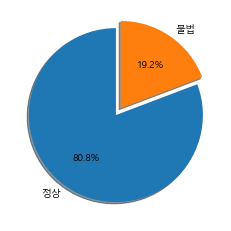

In [61]:
y1_legend = ['정상','불법']
explode = (0, 0.1)
plt.pie(y1_count, labels=y1_legend, autopct ='%0.1f%%', explode=explode, shadow=True, startangle=90)
plt.show()

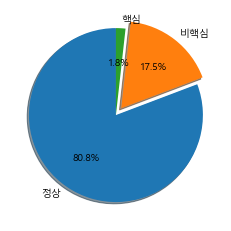

In [62]:
y2_legend = ['정상','비핵심','핵심']
explode = (0, 0.1, 0)
plt.pie(y2_count, labels=y2_legend, autopct ='%0.1f%%', explode=explode, shadow=True, startangle=90)
plt.show()

In [63]:
df_ano.to_csv('./data_syn/df_syn_ano_01.csv', index=False, encoding='utf-8-sig')

In [65]:
df_ano.shape

(3000, 22)